# Data Analysis 3
## In this analysis we will find a list of client names and how many orders they each made

First we connect to the cloud database, run an SQL query for the necessary data and store it in pandas dataframes.
This analysis requires three tables: ``Person``, ``Customer`` and ``SalesOrderHeader``. We could join the tables in a single SQL query, but for simplicity's sake let's merge them with pandas.

In [1]:
import pandas.io.sql as sqlio
import psycopg2
from config import config

params = config()
conn = psycopg2.connect(**params)
sql1 = 'SELECT * FROM \"Person\";'
sql2 = 'SELECT * FROM \"Customer\";'
sql3 = 'SELECT * FROM \"SalesOrderHeader\";'
person = sqlio.read_sql_query(sql1, conn)
customer = sqlio.read_sql_query(sql2, conn)
salesOrderHeader = sqlio.read_sql_query(sql3, conn)
conn.close()

Let's inspect the dataframes.

In [2]:
from IPython.display import display

display(person.head(3))
display(customer.head(3))
display(salesOrderHeader.head(3))

,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1,EM,False,None,Ken,J,Sánchez,None,0,None,<IndividualSurvey xmlns=http://schemas.microso...,92C4279F-1207-48A3-8448-4636514EB7E2,2009-01-07
1,2,EM,False,None,Terri,Lee,Duffy,None,1,None,<IndividualSurvey xmlns=http://schemas.microso...,D8763459-8AA8-47CC-AFF7-C9079AF79033,2008-01-24
2,3,EM,False,None,Roberto,None,Tamburello,None,0,None,<IndividualSurvey xmlns=http://schemas.microso...,E1A2555E-0828-434B-A33B-6F38136A37DE,2007-11-04


,CustomerID,PersonID,StoreID,TerritoryID,AccountNumber,rowguid,ModifiedDate
0,1,NaN,934.0,1,AW00000001,3F5AE95E-B87D-4AED-95B4-C3797AFCB74F,2014-09-12 11:15:07.263
1,2,NaN,1028.0,1,AW00000002,E552F657-A9AF-4A7D-A645-C429D6E02491,2014-09-12 11:15:07.263
2,3,NaN,642.0,4,AW00000003,130774B1-DB21-4EF3-98C8-C104BCD6ED6D,2014-09-12 11:15:07.263


,SalesOrderID,RevisionNumber,OrderDate,DueDate,ShipDate,Status,OnlineOrderFlag,SalesOrderNumber,PurchaseOrderNumber,AccountNumber,...,CreditCardID,CreditCardApprovalCode,CurrencyRateID,SubTotal,TaxAmt,Freight,TotalDue,Comment,rowguid,ModifiedDate
0,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,...,16281,105041Vi84182,None,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07
1,43660,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43660,PO18850127500,10-4020-000117,...,5618,115213Vi29411,None,1294.2529,124.2483,38.8276,1457.3288,None,738DC42D-D03B-48A1-9822-F95A67EA7389,2011-06-07
2,43661,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43661,PO18473189620,10-4020-000442,...,1346,85274Vi6854,4,32726.4786,3153.7696,985.5530,36865.8012,None,D91B9131-18A4-4A11-BC3A-90B6F53E9D74,2011-06-07


Now let's merge them with pandas.

In [3]:
import pandas as pd

df1 = pd.merge(person, customer, how = "inner", left_on = 'BusinessEntityID', right_on = 'PersonID', suffixes = ('_p', '_c'))
df1 = pd.merge( df1, salesOrderHeader, how = "inner", on = 'CustomerID', suffixes = ('', '_soh'))

Here is the resulting dataframe.

In [4]:
display(df1.head(3))

,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,...,CreditCardID,CreditCardApprovalCode,CurrencyRateID,SubTotal,TaxAmt,Freight,TotalDue,Comment,rowguid,ModifiedDate
0,291,SC,False,Mr.,Gustavo,None,Achong,None,2,<AdditionalContactInfo xmlns=http://schemas.mi...,...,None,None,None,4049.9880,388.7988,121.4996,4560.2864,None,BCB75739-C532-4106-93E0-8850819D877B,2011-08-08
1,291,SC,False,Mr.,Gustavo,None,Achong,None,2,<AdditionalContactInfo xmlns=http://schemas.mi...,...,None,None,None,4079.9880,391.6788,122.3996,4594.0664,None,CC2A7DDF-8AE9-4AD8-A5AB-ED1EA7CD635E,2012-02-05
2,291,SC,False,Mr.,Gustavo,None,Achong,None,2,<AdditionalContactInfo xmlns=http://schemas.mi...,...,None,None,None,1104.9968,254.5912,79.5598,1439.1478,None,1C8ED175-0850-4421-9D37-3E8D5E6581D7,2012-05-07


We only need to know the customer's name and how many orders they made, so we can drop most columns to make data visualization easier. Let's create a new dataframe grouped by first and last name with a new column, ``OrderQty``, that will store how many orders that customer has made.

In [5]:
df2 = pd.DataFrame({'Name': df1['FirstName'] + ' ' + df1['LastName'], 'OrderQty': 1}).groupby('Name').sum().reset_index()

Let's see the resulting dataframe.

In [6]:
display(df2)

,Name,OrderQty
0,A. Leonetti,3
1,Aaron Adams,1
2,Aaron Alexander,1
3,Aaron Allen,1
4,Aaron Baker,1
...,...,...
19013,Zoe Rogers,1
19014,Zoe Sanchez,1
19015,Zoe Sanders,1
19016,Zoe Torres,1


We now have a list of all customers by name and how many orders they made. Let's plot this data to a graph and see how it looks. First we will create a new dataframe that stores how many customers have ordered a specific amount of times.

In [7]:
df3 = pd.DataFrame({'OrderQty': df2['OrderQty'], 'Frequency': 1}).groupby('OrderQty').sum().reset_index()

Let's see the resulting dataframe.

In [8]:
display(df3.head(3))

,OrderQty,Frequency
0,1,11527
1,2,5462
2,3,1217


Now let's see how the data looks like in a bar chart.

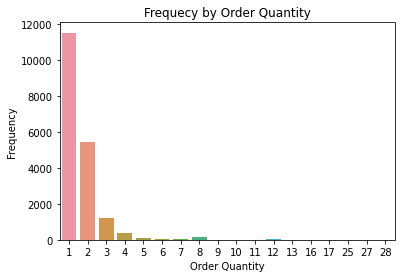

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


g = sns.barplot(x = 'OrderQty', y = 'Frequency', data = df3)
g.set(title = 'Frequecy by Order Quantity', xlabel = 'Order Quantity', ylabel = 'Frequency')
plt.show()

Finally, let's save the resulting dataframe to a ``.csv`` file.

In [10]:
df2.to_csv('results/analysis3.csv')